In [1]:
%load_ext autoreload
%autoreload 2

import copy
import os
import time
import shutil
import itertools
from pprint import pprint
import collections
from collections.abc import Iterable
import math
import numpy as np
import torch
from tqdm import tqdm

from train import *
from util import tensor_items

from tabulate import tabulate
import matplotlib
import matplotlib.pyplot as plt
import plots
from plots import plot

class Break(Exception): pass

def get_command(c):
    return command(c['train_config']['args'])
def command(args):
    return './train.py' + ''.join(f' --{k}={v}' for k, v in args.items())

In [ ]:
out_dir = 'spacebyte'
checkpoints = []
unfinished = 0
idx = 0
Ld = {192:4, 256:8, 384:16, 512:24, 768:32, 1024:32, 1536:48, 2048:48}
Ls = [1, 2, 3, 4, 6, 8, 12, 16, 24, 32, 48]
Bd = {64:256, 128:256, 192:128, 256:64, 384:64, 512:64, 768:64, 1024:64, 1536:64, 2048:64}
for dirpath, _, filenames in tqdm(os.walk(out_dir)):
    if ('stdout.txt' in filenames or 'FINISHED_TRAINING' in filenames) and 'FAILED' not in dirpath:
        if 'FINISHED_TRAINING' not in filenames:
#             age = time.time() - os.path.getmtime(os.path.join(dirpath, 'stdout.txt'))
#             if age > 10*60:
#                 print(f'unfinished age={round(age/60)}m: {dirpath}')
#                 if age > 12*60*60:
#                     print(dirpath)
    #                 shutil.move(dirpath, dirpath + '_FAILED')
            unfinished += 1
        else:
            c = torch.load(os.path.join(dirpath, 'ckpt_small.pt'))
            assert c['iter_num'] + 1 == c['train_config']['iters']
            c['idx'] = idx
            idx += 1
            checkpoints.append(c)
len(checkpoints), unfinished

In [7]:
use_test_loss = True
def get_test_loss(c, *args):
    return c['losses']['test' if use_test_loss else 'val'].get(*args)

model_flags = ['patch_method'] # , 'sparse_attention']

def train_key(c):
    tc = c['train_config']
    mc = c['model_config']
    return (tc['dataset'], tc['args']['iters'])
def model_key(c):
    tc = c['train_config']
    mc = c['model_config']
    flags = [f if mc[f] is True else str(mc[f]) for f in model_flags if mc.get(f, False)]
    key = (tc['model'], str(mc['tokenizer']), *flags)
    if mc['attention_window'] is not None:
        key = (*key, 'attention_window')
    return key

c_dict = collections.defaultdict(list) # {(train_key(c), model_key(c)): checkpoints}
for c in checkpoints:
    c_dict[(train_key(c), model_key(c))].append(c)
c_dict = {**c_dict}

train_keys = sorted(list(set(k[0] for k in c_dict.keys())))
datasets = set(k[0] for k in train_keys)
# model_keys = set(k[1] for k in c_dict.keys())

get_loss = lambda c: get_test_loss(c, 'bits per byte')
def get_flops_per_byte(c):
    return 2*c['mult-add per token'] / c['bytes per token']

c_pareto = c_dict.copy()
for k, cs in sorted(list(c_pareto.items())):
    cs = cs.copy()
    cs.sort(key=get_loss)
    c_pareto[k] = cs
    
    for _pass in range(2):
        i = 0
        while i < len(cs):
            try:
                c = cs[i]
                cL, cF = get_loss(c), get_flops_per_byte(c)
                for c0 in cs:
                    if c0 is not c:
                        c0L, c0F = get_loss(c0), get_flops_per_byte(c0)
                        if _pass == 0:
                            min_slope = 0.01
                            if (cL >= c0L and cF >= c0F) or (cF > c0F and math.log(c0L/cL)/math.log(cF/c0F) < min_slope):
                                del cs[i]
                                raise Break
                        else:
                            for c1 in cs:
                                if c1 is not c and c1 is not c0:
                                    c1L, c1F = get_loss(c1), get_flops_per_byte(c1)
                                    interpolate_loss = ((c0F*c1L - c1F*c0L) + (c0L - c1L)*cF) / (c0F - c1F)
                                    if c0F <= cF <= c1F and interpolate_loss < cL:
                                        del cs[i]
                                        raise Break
                i += 1
            except Break:
                pass

label_style_map = [
    ( ('Transformer', 'gpt2'), 'Transformer\n(GPT2 tokenizer)', 'grey' ),
    ( ('Transformer', 'sp'), 'Transformer\n(SentencePiece)', 'black' ),
    ( ('Transformer', 'None'), 'Transformer', 'blue' ),
    ( ('Transformer', 'None', 'attention_window'), 'Transformer\n(Window Attention)', (.5, 0, .5) ),
    ( ('MegaByte', 'None'), 'MegaByte', 'green' ),
    ( ('SpaceByte', 'None', 'periodic'), 'SpaceByte\n(fixed $P$)', (1,.5,0) ),
    ( ('SpaceByte', 'None', 'utf8'), 'SpaceByte', (.8,0,0) ),
]
label_dict = {mk: l for mk, l, c in label_style_map}
color_dict = {l: c for mk, l, c in label_style_map}

In [103]:
# Table 1
min_loss = {}
max_err = {}
for pass_ in range(2):
    out = ''
    for mk, l in label_dict.items():
        out += '    & ' + l.replace('\n', ' ')
        for dataset in ['pg19', 'arxiv', 'github']:
            k = ((dataset, '1e19/flops'), mk)
            c = c_pareto[k][0]
            loss = get_loss(c)
            if pass_ == 0:
                min_loss[dataset] = min(min_loss.get(dataset, 100), loss)
                err = get_test_loss(c, 'bits per byte stat')
                max_err[dataset] = max(100*err/loss, max_err[dataset] if dataset in max_err else 0)

            if loss / min_loss[dataset] == 1:
                out += ' & \\textbf{\\underline{' + f'{loss:.3f}' + '}}'
            elif loss / min_loss[dataset] <= 1.03:
                out += ' & \\textbf{' + f'{loss:.3f}' + '}'
            else:
                out += f' & {loss:.3f}'
        out += ' \\\\\n'
print(out)
print(f'max stat error % = {max_err}')

    & Transformer (GPT2 tokenizer) & \textbf{1.013} & 0.796 & 0.554 \\
    & Transformer (SentencePiece) & \textbf{\underline{0.989}} & \textbf{0.768} & \textbf{0.508} \\
    & Transformer & 1.138 & 0.909 & 0.655 \\
    & Transformer (Window Attention) & 1.089 & 0.818 & 0.560 \\
    & MegaByte & 1.083 & 0.822 & 0.570 \\
    & SpaceByte (fixed $P$) & 1.112 & 0.804 & 0.552 \\
    & SpaceByte & \textbf{1.009} & \textbf{\underline{0.748}} & \textbf{\underline{0.500}} \\

max stat error % = {'pg19': 0.045683369226485346, 'arxiv': 0.08655754834537537, 'github': 0.39638783060551674}


In [85]:
# Table 3
out = ''
for mk, l in label_dict.items():
    out += '  \multirow{3}{*}{\makecell{' + l.replace('\n', '\\\\') + '}}\n'
    for dataset in ['pg19', 'arxiv', 'github']:
        k = ((dataset, '1e19/flops'), mk)
        c = c_pareto[k][0]
        M = lambda x: f'{round(x/1e6)}M'
        dataset_ = dict(pg19='PG-19', arxiv='arXiv', github='Github')[dataset]
        mc = c['model_config']
        L = mc['n_layers']
        l = mc.get('n_local_layers')
        D = mc['d_model']
        d = mc.get('d_local')
        V = mc['vocab_size']
        T = mc['context_size']
        if 'Transformer' in mk[0]:
            param = M(L*4*D*D + L*2*4*D*D + D*V)
        elif 'MegaByte' in mk[0]:
            P = mc['patch_size']
            param = M(L*4*D*D + L*2*4*D*D) + '+' + M(d*D/P + l*4*d*d + l*2*4*d*d + d*V)
        elif 'SpaceByte' in mk[0]:
            param = M(L*4*D*D + L*2*4*D*D) + '+' + M(l*4*d*d + l*2*4*d*d + d*V)
        layers = f'${L} / {l}$' if l else L
        dim = f'${D} / {d}$' if d else D
        out += f'    & {dataset_} & {param} & {M(get_flops_per_byte(c))} & {layers} & {dim} & {T} \\\\\n'
    out += '  \midrule \n'
print(out)

  \multirow{3}{*}{\makecell{Transformer\\(GPT2 tokenizer)}}
    & PG-19 & 454M & 279M & 32 & 1024 & 1024 \\
    & arXiv & 253M & 202M & 16 & 1024 & 1024 \\
    & Github & 253M & 253M & 16 & 1024 & 1024 \\
  \midrule 
  \multirow{3}{*}{\makecell{Transformer\\(SentencePiece)}}
    & PG-19 & 454M & 260M & 32 & 1024 & 1024 \\
    & arXiv & 253M & 155M & 16 & 1024 & 1024 \\
    & Github & 253M & 182M & 16 & 1024 & 1024 \\
  \midrule 
  \multirow{3}{*}{\makecell{Transformer}}
    & PG-19 & 202M & 470M & 16 & 1024 & 1024 \\
    & arXiv & 202M & 470M & 16 & 1024 & 1024 \\
    & Github & 202M & 470M & 16 & 1024 & 1024 \\
  \midrule 
  \multirow{3}{*}{\makecell{Transformer\\(Window Attention)}}
    & PG-19 & 227M & 529M & 32 & 768 & 4608 \\
    & arXiv & 202M & 470M & 16 & 1024 & 6144 \\
    & Github & 202M & 470M & 16 & 1024 & 8192 \\
  \midrule 
  \multirow{3}{*}{\makecell{MegaByte}}
    & PG-19 & 201M+51M & 219M & $16 / 16$ & $1024 / 512$ & 4096 \\
    & arXiv & 201M+51M & 219M & $16 / 16$ & 

pg19


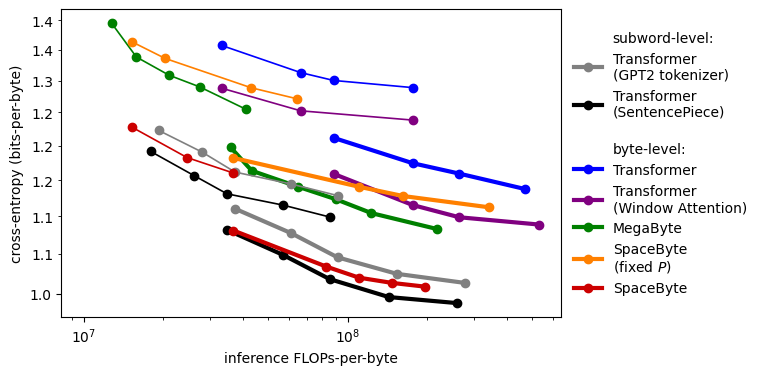

arxiv


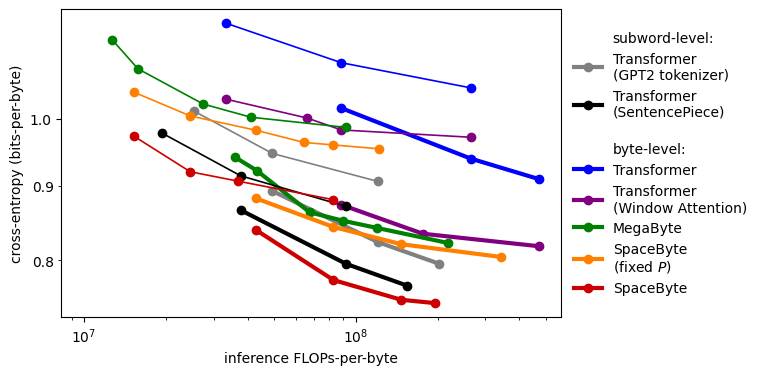

github


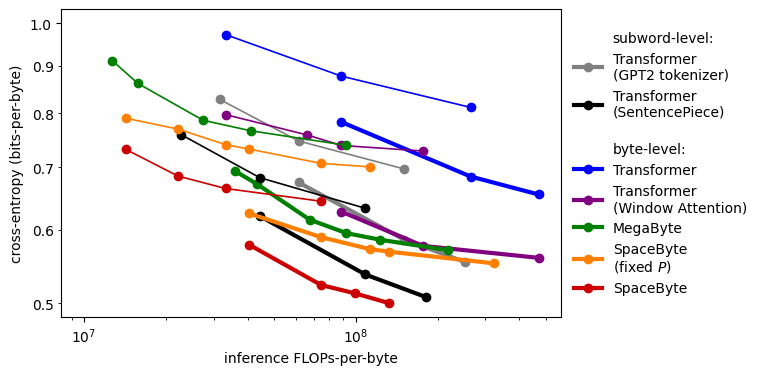

pg19


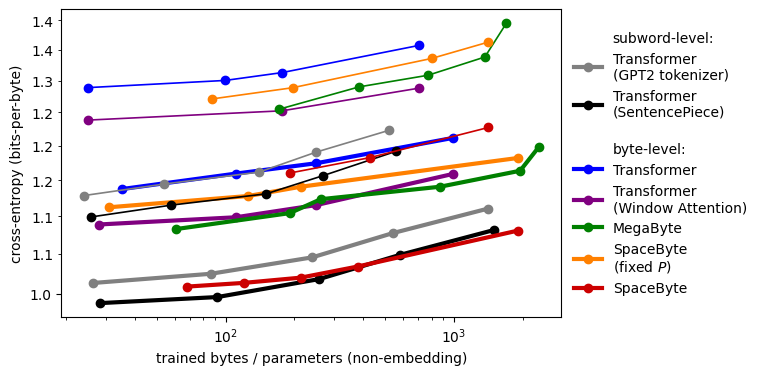

arxiv


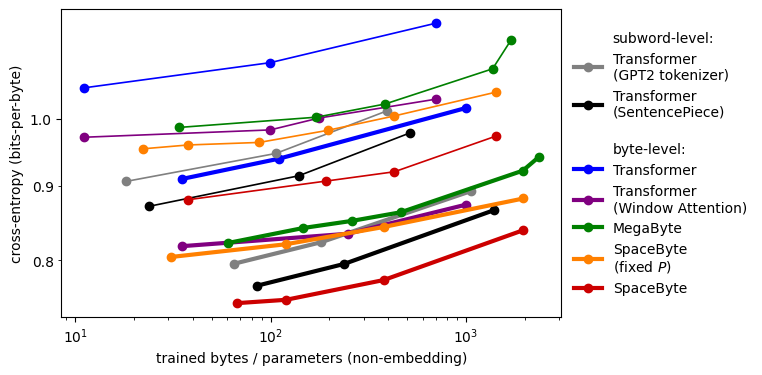

github


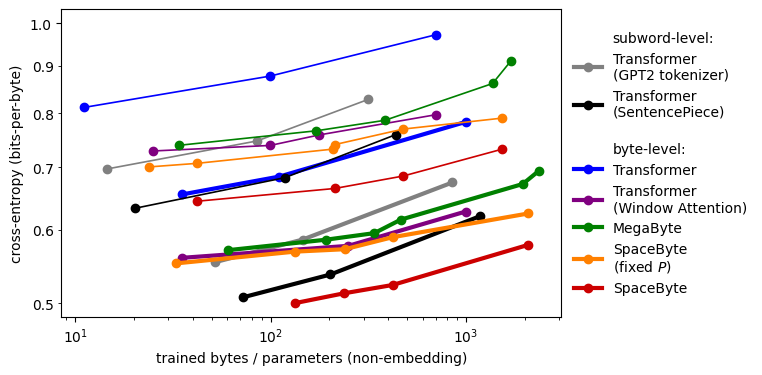

In [86]:
# Figures 3 and 4
use_test_loss=True
rand_color_dict = color_dict.copy()
def get_color(l):
    if l not in rand_color_dict:
        rand_color_dict[l] = tuple(np.random.rand(3))
    return rand_color_dict[l]
def get_label(c):
    return label_dict.get(model_key(c), None)
for xk in range(0,2):
    for dataset in ['pg19', 'arxiv', 'github']:
        plt.figure(figsize=(8,4))
        plt.subplots_adjust(right=0.75)
        print(dataset)
        legend = dict(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
        for k in train_keys[::-1]:
            if k[0] == dataset:
                linewidth = 3 if k[1] == '1e19/flops' else 1.2
                def add_fake_labels(data):
                    if legend:
                        x0 = 1e7 if xk==0 else 1e2
                        return [([x0], [1], 'subword-level:', dict(color=(0,0,0,0)))] + data[:2] + \
                               [([x0], [1], '\nbyte-level:' , dict(color=(0,0,0,0)))] + data[2:]
                    else:
                        return data
                def get_bytes_per_param(c):
                    return c['train tokens'] * c['bytes per token'] / c['non-embedding parameters']
                plots.plot_data(itertools.chain(*c_pareto.values()), [get_flops_per_byte, get_bytes_per_param][xk], get_loss,
                    lambda c: get_label(c) if train_key(c) == k else None,
                    ('log', 'log'),
                    options_func=lambda l: dict(color=get_color(l), linewidth=linewidth),
                    labels = (['inference FLOPs-per-byte', 'trained bytes / parameters (non-embedding)'][xk], 'cross-entropy (bits-per-byte)', None),
                    legend_labels=list(color_dict.keys()),
                    new_figure=False, legend=legend,
                    post_process=add_fake_labels, args=['o-'])
                legend = False
        plt.gca().yaxis.set_minor_formatter(matplotlib.ticker.StrMethodFormatter('{x:.1f}'))
        plt.gca().yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:.1f}'))
        os.makedirs('spacebyte-paper', exist_ok=True)
        plt.savefig(f'spacebyte-paper/{dataset}' + ['_val',''][use_test_loss] + ['','_param'][xk] + '.pdf', bbox_inches='tight')
        plt.show()